In [1]:
import numpy as np
import pandas as pd 
import random
import TimeSeries_Clustering
from tqdm import tqdm 
import matplotlib.pyplot as plt
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import sigma_gak, cdist_gak
from sklearn.metrics.cluster import adjusted_rand_score
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
import xgboost
import gc
import Evrecsys
import sys
from itertools import combinations, groupby
from collections import Counter
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
import Apriori
import lightfm_form
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
from lightfm import LightFM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from statistics import mode
import networkx as nx
from community import community_louvain
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

In [2]:
def create_item_emdedding_distance_matrix(model,interactions):
    df_item_norm_sparse = sparse.csr_matrix(model.item_embeddings)
    similarities = cosine_similarity(df_item_norm_sparse)
    item_emdedding_distance_matrix = pd.DataFrame(similarities)
    item_emdedding_distance_matrix.columns = interactions.columns
    item_emdedding_distance_matrix.index = interactions.columns
    return item_emdedding_distance_matrix

def create_user_dict(interactions):
    '''
    Function to create a user dictionary based on their index and number in interaction dataset
    Required Input - 
        interactions - dataset create by create_interaction_matrix
    Expected Output -
        user_dict - Dictionary type output containing interaction_index as key and user_id as value
    '''
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

def create_item_dict(df,id_col,name_col):
    '''
    Function to create an item dictionary based on their item_id and item name
    Required Input - 
        - df = Pandas dataframe with Item information
        - id_col = Column name containing unique identifier for an item
        - name_col = Column name containing name of the item
    Expected Output -
        item_dict = Dictionary type output containing item_id as key and item_name as value
    '''
    item_dict ={}
    for i in range(df.shape[0]):
        item_dict[(df.loc[i,id_col])] = df.loc[i,name_col]
    return item_dict

def runMF(interactions, n_components, loss, epoch,n_jobs, item_features):
    x = sparse.csr_matrix(interactions.values)
    user_features=sparse.csr_matrix(user_features.values)
    item_features=sparse.csr_matrix(item_features.values)
    model = LightFM(no_components= n_components, loss=loss,learning_schedule='adagrad')
    model.fit(x,epochs=epoch,num_threads = n_jobs, user_features=user_features,
          item_features=item_features)
    return model



In [60]:
#Import Data
merchants = pd.read_csv('merchants.csv')
test = pd.read_csv('test.csv', parse_dates=["first_active_month"])
train = pd.read_csv('train.csv', parse_dates=["first_active_month"])
#historical_transactions = pd.read_csv('historical_transactions.csv', parse)
#new_merchant_transactions = pd.read_csv('new_merchant_transactions.csv')
data=pd.read_csv('data_cards_0.csv', parse_dates=['purchase_date'])
card_list=data.card_id.unique()
test= test[test.card_id.isin(card_list)]
train= train[train.card_id.isin(card_list)]

In [61]:
def missing_impute(df):
    for i in df.columns:
        if df[i].dtype == "object":
            df[i] = df[i].fillna("other")
        elif (df[i].dtype == "int64" or df[i].dtype == "float64"):
            df[i] = df[i].fillna(df[i].mean())
        else:
            pass
    return df

In [62]:
# Do impute missing values for all datasets
##for df in [train, test, merchants, historical_transactions, new_merchant_transactions]:
    #missing_impute(df)
for df in [train, test, merchants, data]:
    missing_impute(df)

In [63]:
#data = historical_transactions.append(new_merchant_transactions)

le = preprocessing.LabelEncoder()
le.fit(merchants['category_1'])
merchants['category_1']=le.transform(merchants['category_1']) 

le.fit(merchants['most_recent_sales_range'])
merchants['most_recent_sales_range']=le.transform(merchants['most_recent_sales_range']) 

le.fit(merchants['most_recent_purchases_range'])
merchants['most_recent_purchases_range']=le.transform(merchants['most_recent_purchases_range']) 

le.fit(merchants['category_4'])
merchants['category_4']=le.transform(merchants['category_4']) 

In [64]:
#number of transactions
gdf = data.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_transactions"]
train = pd.merge(train, gdf, on="card_id", how="left")
test= pd.merge(test, gdf, on="card_id", how="left")

In [65]:
#Stadistics about purchase amount in new merch
gdf = data.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_trans", "mean_trans", "std_trans", "min_trans", "max_trans"]
train = pd.merge(train, gdf, on="card_id", how="left")
test = pd.merge(test, gdf, on="card_id", how="left")

In [66]:
train["year_first"] = train["first_active_month"].dt.year
test["year_first"] = test["first_active_month"].dt.year
train["month_first"] = train["first_active_month"].dt.month
test["month_first"] = test["first_active_month"].dt.month
data["year_purch"] = data["purchase_date"].dt.year
data["month_purch"] = data["purchase_date"].dt.month
data["year_month_purch"] = data["purchase_date"].dt.strftime('%Y/%m')

## Clustering

### Time Series

In [67]:
def make_timeseries(new_transactions):
    cross_ts = pd.crosstab(new_transactions.card_id, new_transactions.year_month_purch, values=new_transactions.purchase_amount, aggfunc='sum')
    cross_ts1 = cross_ts.fillna(0).values.tolist()
    return cross_ts1, cross_ts.index

In [68]:
def cluster_kshape(train, test, data,return_pred, num_cluster):
    ts, ts_index=make_timeseries(data)
    sum_pred_test=pd.DataFrame()
    formatted_dataset = to_time_series_dataset(ts)
    X_train, sz = TimeSeries_Clustering.normalize_data(formatted_dataset)
    ks, y_pred = TimeSeries_Clustering.k_shape(X_train, n_clusters=num_cluster)
    scores = TimeSeries_Clustering.compute_scores(ks, X_train, y_pred)
    plt.boxplot(scores)

    TimeSeries_Clustering.plot_data(ks, X_train, y_pred, sz, ks.n_clusters, centroid=True)
    y_pred_df = pd.DataFrame(y_pred)
    y_pred_df['card_id'] = ts_index
    y_pred_df= y_pred_df.rename({0: 'cluster_kshape'}, axis='columns')
    y_pred_df.to_csv('clusters_kshape.csv')
    return y_pred_df
   

### Features

In [69]:
def cluster_features(train, test, data,return_pred, num_cluster):
    random_state=2
    train_test=train.append(test)
    train_test1=train_test.drop(['card_id', 'first_active_month', 'target'], axis=1)
    y_pred_test = KMeans(n_clusters=num_cluster, random_state=random_state).fit_predict(train_test1)
    y_pred_test_df = pd.DataFrame(y_pred_test)
    y_pred_test_df['card_id'] = train_test.card_id.values
    y_pred_test_df= y_pred_test_df.rename({0: 'cluster_features'}, axis='columns')
    y_pred_test_df.to_csv('clusters_features.csv')
    return y_pred_test_df

### Graph

In [70]:
def cluster_graph(train, test, data,return_pred, num_cluster):
    FG = nx.from_pandas_edgelist(data, source='card_id', target='merchant_id', edge_attr=True)
    parts = community_louvain.best_partition(FG)
    y_pred_df = pd.DataFrame.from_dict(parts, orient='index', columns=['cluster_graph']).reset_index()
    y_pred_df=y_pred_df.rename({'index': 'card_id'}, axis='columns')
    y_pred_df.to_csv('clusters_graph.csv')
    return y_pred_df
    

## Methods

In [71]:
cols_to_use=['feature_1', 'feature_2', 'feature_3',
        'num_transactions', 'sum_trans', 'mean_trans',
       'std_trans', 'min_trans', 'max_trans', 'year_first', 'month_first']
target_col=['target']

In [72]:
##XGBOOST

def do_xgboost(train, test, data,return_pred, num_cluster):
    param = {'max_depth': 10,
                 'eta': 0.02,
                 'colsample_bytree': 0.4,
                 'subsample': 0.75,
                 'silent': 1,
                 'nthread': 27,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'tree_method': 'hist'
                 }
    
    X_train=train[cols_to_use]
    X_test=test[cols_to_use]
    y_train=train[target_col].values
    y_test=test[target_col].values
    
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dtest = xgboost.DMatrix(X_test)
    model = xgboost.train(param, dtrain)
    predict_test = pd.DataFrame({"card_id":test["card_id"].values})
    predict_test["target"] = pd.DataFrame(model.predict(dtest))
    if return_pred==0:
        return np.sqrt(mean_squared_error(predict_test.target.values, y_test)), predict_test
    else:
        return np.sqrt(mean_squared_error(predict_test.target.values, y_test)), predict_val, y_val, predict_test


In [73]:
## Last_order

def avg_merchant(train, test, data,return_pred, num_cluster):
    train=train.merge(data, on='card_id', how='left')
    train_avgtarget = train.groupby(["merchant_id"])["target"].aggregate("mean").reset_index()
    train=train.merge(train_avgtarget, on='merchant_id', how='left')
    test=test.merge(data, on='card_id', how='left')
    test=test.merge(train_avgtarget, on='merchant_id', how='left').fillna(train_avgtarget.target.mean())
    pred=test.groupby(["card_id"])["target_y"].aggregate("mean").reset_index()
    pred=pred.merge(test[['card_id','target_x']], on='card_id',how='left').drop_duplicates()
    return np.sqrt(mean_squared_error(pred.target_y, pred.target_x))
    if return_pred==0:
        return np.sqrt(mean_squared_error(predict_test.target.values, y_test)), predict_test
    else:
        return np.sqrt(mean_squared_error(predict_test.target.values, y_test)), predict_val, y_val, predict_test
    

In [74]:
## Lightfm

def do_lightfm(train, test, data,return_pred, num_cluster):
    train=train.merge(data, on='card_id', how='left')
    train_avgtarget = train.groupby(["merchant_id"])["target"].aggregate("mean").reset_index()
    train=train.merge(train_avgtarget, on='merchant_id', how='left')
    test=test.merge(data, on='card_id', how='left')
    test=test.merge(train_avgtarget, on='merchant_id', how='left')
    test_train=train.append(test)
    grouped_train_test = test_train.groupby(["merchant_id", "card_id"])["target_y"].aggregate("mean").reset_index()
    interactions = lightfm_form.create_interaction_matrix(df=grouped_train_test,user_col='merchant_id',item_col='card_id',rating_col='target_y')
    train_unique=train.drop_duplicates(subset=['card_id'])
    test_unique=test.drop_duplicates(subset=['card_id'])
    item_features= train_unique.append(test_unique)[['feature_1', 'feature_2', 'feature_3',
       'num_transactions', 'sum_trans', 'mean_trans', 'std_trans', 'min_trans',
       'max_trans', 'year_first', 'month_first']]
    mf_model = lightfm_form.runMF(interactions=interactions,
                                  n_components=30, loss='warp', epoch=40, n_jobs=4)
    # Create User Dict
    user_dict = create_user_dict(interactions=interactions)
    # Create Item dict
    products_dict = create_item_dict(df = data.reset_index(),
                               id_col = 'card_id',
                               name_col = 'card_id')
    ## Creating item-item distance matrix
    item_item_dist = create_item_emdedding_distance_matrix(model = mf_model,
                                                       interactions = interactions)
    
    scores_rmse=pd.DataFrame(columns=['card_id', 'pred'])

    for cards in test.card_id.unique():
        recommended_items = list(pd.Series(item_item_dist.loc[cards,:]. \
                                  sort_values(ascending = False).head(10+1). \
                                  index[1:10+1]))
        recommended_train=list(train_unique[train_unique.card_id.isin(recommended_items)].card_id.values)
        pred=train_unique.loc[train_unique['card_id'].isin(recommended_train)]
        scores_rmse=scores_rmse.append(
            {'card_id': cards, 'pred': pred.target_x.mean()},ignore_index=True)
    scores_rmse=scores_rmse.merge(test_unique[['card_id', 'target_x']], on='card_id')
    scores_rmse=scores_rmse.fillna(scores_rmse.pred.mean())
    if return_pred==0:
        return np.sqrt(mean_squared_error(scores_rmse.pred, scores_rmse.target_x)), scores_rmse
    else:
        return np.sqrt(mean_squared_error(scores_rmse.pred, scores_rmse.target_x)), scores_rmse

    
    

In [75]:
## Catboost
def catboost(train, test, data,return_pred, num_cluster):
    model_cat = CatBoostRegressor(iterations=500,
                             learning_rate=0.02,
                             depth=6,
                             eval_metric='RMSE',
                             bagging_temperature = 0.9,
                             od_type='Iter',
                             metric_period = 100,
                             od_wait=50)
    X_train=train[cols_to_use]
    X_test=test[cols_to_use]
    y_train=train[target_col]
    y_test=test[target_col]
    
    model_cat.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        cat_features=np.array([0,1,2]),
        verbose=None,
        early_stopping_rounds=100)
    
    predict_test = pd.DataFrame({"card_id":test["card_id"].values})
    predict_test["target"] = pd.DataFrame(model_cat.predict(X_test))
    if return_pred==0:
        return np.sqrt(mean_squared_error(predict_test.target.values, y_test)), predict_test
    else:
        return np.sqrt(mean_squared_error(predict_test.target.values, y_test)), predict_val, y_val, predict_test


In [76]:
train, test = train_test_split(train, test_size=0.3)

### Clustering-Methods

cluster_kshape
0.112 --> 0.096 --> 0.092 --> 0.092 --> 0.095 --> 


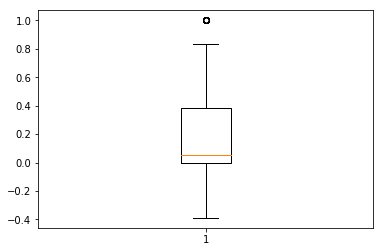

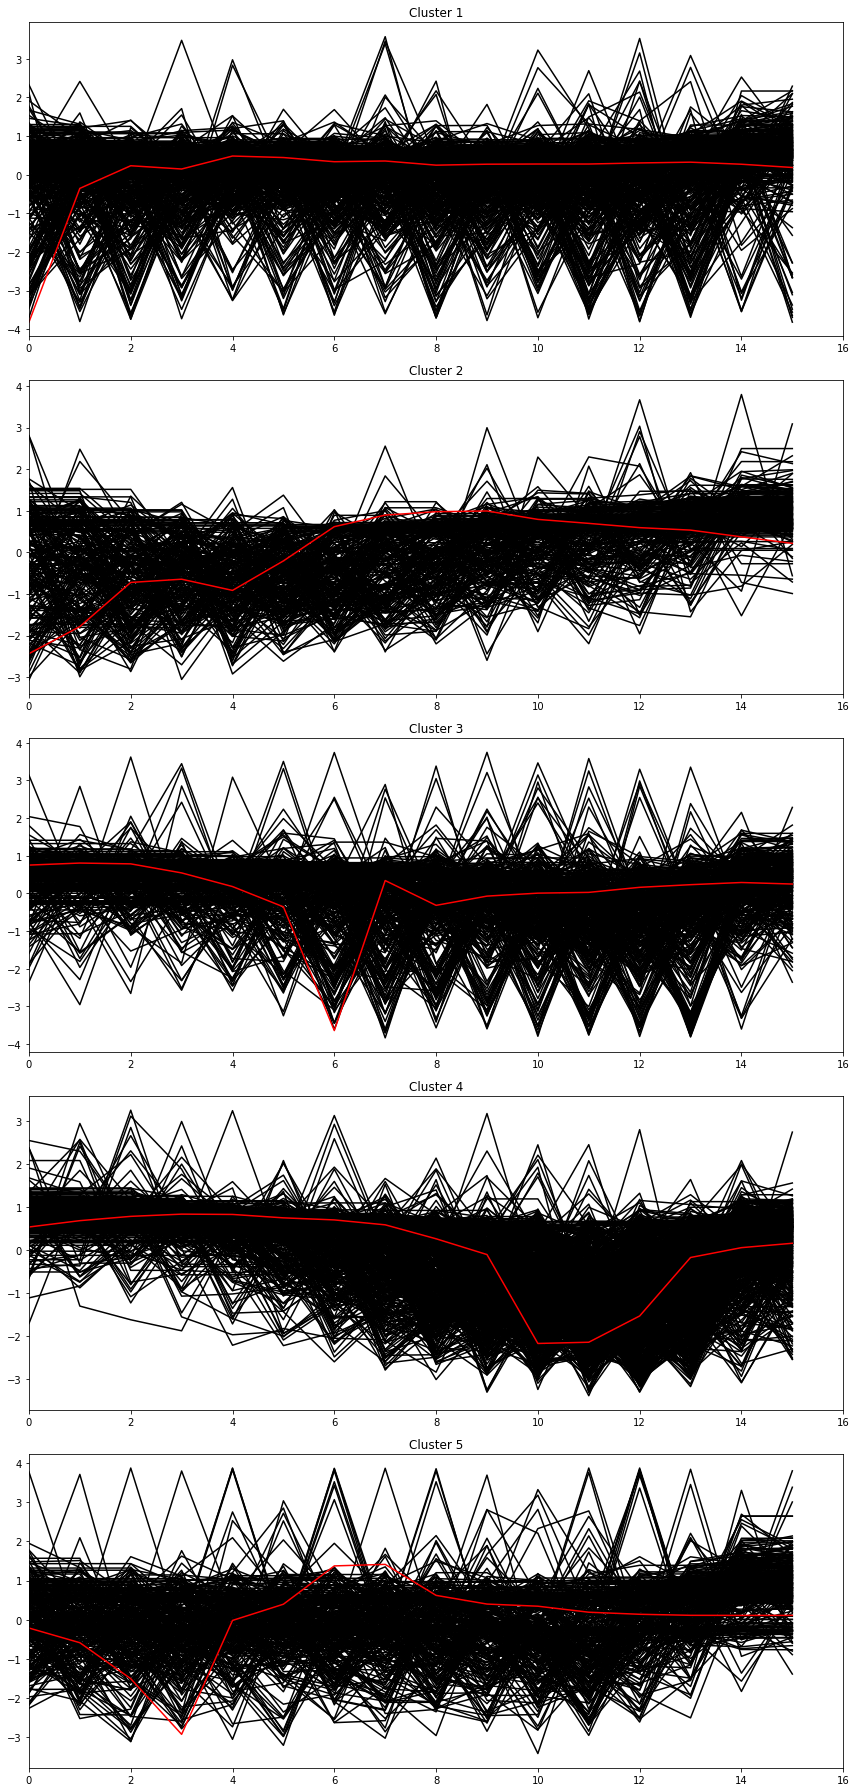

2
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:47:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f2426c972f0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f2426c97510>


0:	learn: 3.3015494	test: 3.3129437	test1: 1.9776884	best: 1.9776884 (0)	total: 54.2ms	remaining: 27s
100:	learn: 2.8319989	test: 3.0994816	test1: 2.0258855	best: 1.9738260 (2)	total: 367ms	remaining: 1.45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.973826008
bestIteration = 2

Shrink model to first 3 iterations.
3
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:47:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f2426c972f0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f2426c97510>


0:	learn: 2.3756584	test: 2.3756584	test1: 4.3046438	best: 4.3046438 (0)	total: 1.69ms	remaining: 845ms
100:	learn: 2.2854183	test: 2.3010991	test1: 4.2806490	best: 4.2806267 (99)	total: 378ms	remaining: 1.49s
200:	learn: 2.2116001	test: 2.2499246	test1: 4.2760652	best: 4.2740603 (138)	total: 731ms	remaining: 1.09s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 4.27406025
bestIteration = 138

Shrink model to first 139 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


1
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:47:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f2426c972f0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f2426c97510>
0:	learn: 3.5552285	test: 3.5611141	test1: 7.1969038	best: 7.1969038 (0)	total: 3.93ms	remaining: 1.96s
100:	learn: 3.0469907	test: 3.2602249	test1: 7.0387859	best: 7.0385811 (98)	total: 232ms	remaining: 915ms
200:	learn: 2.5775929	test: 3.0997437	test1: 7.0231547	best: 7.0231547 (200)	total: 502ms	remaining: 747ms
300:	learn: 2.1895183	test: 2.8799615	test1: 7.0153620	best: 7.0140643 (287)	total: 754ms	remaining: 498ms
400:	learn: 1.8727046	test: 2.6946262	test1: 6.9798955	best: 6.9798955 (400)	total: 1.05s	remaining: 259ms
499:	learn: 1.6696237	test: 2.6070753	test1: 6.9701934	best: 6.9689743 (492)	total: 1.38s	remaining: 0us

bestTest = 6.968974276
bestIteration = 492

Shrink model to first 493 iterations.
0
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:47:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f2426c972f0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f2426c97510>


0:	learn: 3.2547718	test: 3.2547718	test1: 6.9977747	best: 6.9977747 (0)	total: 4.29ms	remaining: 2.14s
100:	learn: 2.8917965	test: 2.9813265	test1: 7.0390910	best: 6.9977747 (0)	total: 288ms	remaining: 1.14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 6.997774676
bestIteration = 0

Shrink model to first 1 iterations.
4
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:47:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f2426c972f0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f2426c97510>
0:	learn: 3.3879826	test: 3.3884858	test1: 5.1931773	best: 5.1931773 (0)	total: 6.19ms	remaining: 3.09s
100:	learn: 3.0445967	test: 3.1354167	test1: 5.1380583	best: 5.1358677 (93)	total: 338ms	remaining: 1.33s
200:	learn: 2.7813305	test: 2.9382788	test1: 5.1330676	best: 5.1215596 (181)	total: 608ms	remaining: 904ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 5.121559623
bestIteration = 181

Shrink model to first 182 iterations.
cluster_features


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:47:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f2426c972f0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f2426c97510>
0:	learn: 3.1665751	test: 3.1665751	test1: 5.2009057	best: 5.2009057 (0)	total: 1.04ms	remaining: 519ms
100:	learn: 3.0047060	test: 3.0743787	test1: 5.2034307	best: 5.1953468 (18)	total: 360ms	remaining: 1.42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 5.195346792
bestIteration = 18

Shrink model to first 19 iterations.
2
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:47:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f2426c972f0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f2426c97510>


0:	learn: 3.3040146	test: 3.3040146	test1: 5.0630778	best: 5.0630778 (0)	total: 6.27ms	remaining: 3.13s
100:	learn: 2.8226741	test: 2.9109072	test1: 5.0857179	best: 5.0557793 (30)	total: 402ms	remaining: 1.59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 5.055779253
bestIteration = 30

Shrink model to first 31 iterations.
3
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:47:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f2426c972f0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f2426c97510>


0:	learn: 1.2608199	test: 1.2617937	test1: 5.8255986	best: 5.8255986 (0)	total: 5.04ms	remaining: 2.52s
100:	learn: 1.0683017	test: 1.1070597	test1: 5.7583663	best: 5.7583663 (100)	total: 269ms	remaining: 1.06s
200:	learn: 0.9555655	test: 1.0184208	test1: 5.7399617	best: 5.7395604 (187)	total: 525ms	remaining: 781ms
300:	learn: 0.8338792	test: 0.9201930	test1: 5.7170444	best: 5.7167368 (291)	total: 757ms	remaining: 500ms
400:	learn: 0.7109684	test: 0.8222554	test1: 5.7133280	best: 5.7097638 (390)	total: 1.06s	remaining: 261ms
499:	learn: 0.6081127	test: 0.7398557	test1: 5.7010463	best: 5.7009054 (498)	total: 1.34s	remaining: 0us

bestTest = 5.700905374
bestIteration = 498

Shrink model to first 499 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


4
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:47:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f2426c972f0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f2426c97510>
0:	learn: 0.5727174	test: 0.5727174	test1: 0.5117552	best: 0.5117552 (0)	total: 535us	remaining: 267ms
100:	learn: 0.3059922	test: 0.3347843	test1: 0.6998887	best: 0.5117552 (0)	total: 143ms	remaining: 565ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.511755193
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


1
xgboost
<function do_xgboost at 0x7f2426c97b70>
do_lightfm
<function do_lightfm at 0x7f2426c972f0>
catboost
<function catboost at 0x7f2426c97510>
cluster_graph
13
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:48:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f2426c972f0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f2426c97510>
0:	learn: 1.9079794	test: 1.9091841	test1: 1.7265906	best: 1.7265906 (0)	total: 1.11ms	remaining: 553ms
100:	learn: 1.6143659	test: 1.7146540	test1: 1.8448293	best: 1.7265906 (0)	total: 231ms	remaining: 913ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.726590589
bestIteration = 0

Shrink model to first 1 iterations.
28
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:48:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f2426c972f0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f2426c97510>


0:	learn: 1.1878138	test: 1.1878138	test1: 1.8189256	best: 1.8189256 (0)	total: 2.43ms	remaining: 1.21s
100:	learn: 0.6929136	test: 0.7027423	test1: 1.1702783	best: 1.1702783 (100)	total: 106ms	remaining: 417ms
200:	learn: 0.4103470	test: 0.4438963	test1: 0.8397824	best: 0.8397824 (200)	total: 197ms	remaining: 293ms
300:	learn: 0.2510165	test: 0.3057996	test1: 0.6990797	best: 0.6990797 (300)	total: 269ms	remaining: 178ms
400:	learn: 0.1656911	test: 0.2318281	test1: 0.6485481	best: 0.6483939 (399)	total: 368ms	remaining: 90.8ms
499:	learn: 0.1126953	test: 0.1915371	test1: 0.6293509	best: 0.6293509 (497)	total: 470ms	remaining: 0us

bestTest = 0.6293509343
bestIteration = 497

Shrink model to first 498 iterations.
36
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:48:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
do_lightfm
<function do_lightfm at 0x7f2426c972f0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence

catboost
<function catboost at 0x7f2426c97510>
0:	learn: 6.6134435	test: 6.6129457	test1: 1.2145235	best: 1.2145235 (0)	total: 2.21ms	remaining: 1.1s
100:	learn: 4.8893355	test: 5.2044886	test1: 1.9044052	best: 1.2038809 (2)	total: 182ms	remaining: 718ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.203880863
bestIteration = 2

Shrink model to first 3 iterations.
3
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:48:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f2426c972f0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f2426c97510>


0:	learn: 3.4423593	test: 3.4463041	test1: 5.5603469	best: 5.5603469 (0)	total: 6.62ms	remaining: 3.3s
100:	learn: 2.9731805	test: 3.0342324	test1: 5.5410471	best: 5.5344170 (57)	total: 264ms	remaining: 1.04s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 5.534416998
bestIteration = 57

Shrink model to first 58 iterations.
15
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:48:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f2426c972f0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f2426c97510>


0:	learn: 1.9061829	test: 1.9065211	test1: 1.6612118	best: 1.6612118 (0)	total: 4.35ms	remaining: 2.17s
100:	learn: 1.3958251	test: 1.4970535	test1: 1.8316834	best: 1.6612118 (0)	total: 176ms	remaining: 694ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.661211775
bestIteration = 0

Shrink model to first 1 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


2
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:48:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f2426c972f0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f2426c97510>
0:	learn: 1.4764096	test: 1.4764096	test1: 1.5849435	best: 1.5849435 (0)	total: 639us	remaining: 319ms
100:	learn: 1.2389506	test: 1.2668235	test1: 1.5510051	best: 1.5510051 (100)	total: 243ms	remaining: 959ms
200:	learn: 1.0691211	test: 1.1235504	test1: 1.5088310	best: 1.5088310 (200)	total: 507ms	remaining: 754ms
300:	learn: 0.9365111	test: 1.0144381	test1: 1.4804302	best: 1.4760346 (277)	total: 761ms	remaining: 503ms
400:	learn: 0.8037440	test: 0.9102526	test1: 1.4630648	best: 1.4620030 (394)	total: 1.02s	remaining: 253ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.462003042
bestIteration = 394

Shrink model to first 395 iterations.
1
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:48:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f2426c972f0>


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


catboost
<function catboost at 0x7f2426c97510>
0:	learn: 1.7064747	test: 1.7118424	test1: 2.0717977	best: 2.0717977 (0)	total: 2.46ms	remaining: 1.23s
100:	learn: 1.1876981	test: 1.2516611	test1: 2.0231555	best: 2.0215362 (99)	total: 219ms	remaining: 864ms
200:	learn: 0.8964124	test: 1.0358252	test1: 2.0375736	best: 2.0168990 (139)	total: 375ms	remaining: 557ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.016899036
bestIteration = 139

Shrink model to first 140 iterations.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


11
xgboost
<function do_xgboost at 0x7f2426c97b70>
[14:48:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


do_lightfm
<function do_lightfm at 0x7f2426c972f0>


In [ ]:
clustering_list=[cluster_kshape, cluster_features, cluster_graph]
clustering_name=['cluster_kshape', 'cluster_features', 'cluster_graph']
methods_list=[do_xgboost, do_lightfm, catboost]
methods_name=['xgboost', 'do_lightfm', 'catboost']
return_pred=0
sum_pred_test=pd.DataFrame()
scores_cluster=pd.DataFrame(columns=['cluster_type', 'cluster_number','method', 'rmse'])
num_cluster=5
i=0


for clustering in clustering_list:
    print(clustering_name[i])
    cluster_pred=clustering(train, test, data,return_pred, num_cluster)
    test = test.merge(cluster_pred, on='card_id')
    train = train.merge(cluster_pred, on='card_id')
    clusters = train['%s'%clustering_name[i]].unique()
    for cluster in clusters:
        print(cluster)
        train_i = train[train['%s'%clustering_name[i]] == cluster]
        test_i = test[test['%s'%clustering_name[i]] == cluster]
        sum_rmse=0
        j=0
        for method in methods_list:
            print(methods_name[j])
            print(method)
            if len(test_i) != 0:
                rmse, y_pred = method(train_i,test_i, data,return_pred, num_cluster)
            else:
                rmse=np.nan
                y_pred=pd.DataFrame.from_dict({"card_id":[0], 'target':[0]})
            scores_cluster = scores_cluster.append(
            {'cluster_type': clustering_name[i], 'cluster_number': cluster, 'method': methods_name[j], 'rmse': rmse},
            ignore_index=True)
            scores_cluster.to_csv('scores_clustering.csv')
            sum_pred_test=sum_pred_test.append(y_pred)
            #sum_pred_test.to_csv('scores_clustering.csv')
            j = j + 1
    i=i+1
            
            
      

In [ ]:
scores_cluster

In [34]:
train_i

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_new_transactions,sum_trans,mean_trans,std_trans,min_trans,max_trans,year_first,month_first,cluster_kshape
0,2016-12-01,C_ID_ad244c0dd7,5,1,1,0.132423,220.0,-148.740182,-0.676092,0.127487,-0.742986,0.543870,2016,12,4
3,2016-12-01,C_ID_f4bffcbfe0,2,2,0,4.241923,20.0,-13.935362,-0.696768,0.025497,-0.728876,-0.631204,2016,12,4
6,2014-12-01,C_ID_be8cd36969,3,3,1,4.393702,30.0,-22.038318,-0.734611,0.009720,-0.743902,-0.709342,2014,12,4
25,2015-07-01,C_ID_abb24ae90d,4,2,0,0.000000,14.0,-9.699373,-0.692812,0.003820,-0.694315,-0.683796,2015,7,4
26,2014-06-01,C_ID_89507980d9,3,3,1,0.079851,51.0,-35.719341,-0.700379,0.042925,-0.737922,-0.536537,2014,6,4
28,2016-12-01,C_ID_908577d745,2,2,0,-2.068132,97.0,-59.353820,-0.611895,0.227335,-0.740897,0.785796,2016,12,4
35,2017-08-01,C_ID_4327e271ef,2,2,0,-1.802034,9.0,17.082033,1.898004,2.908416,-0.533982,8.645714,2017,8,4
56,2017-05-01,C_ID_d22e4d142e,3,2,1,0.497682,279.0,-199.051528,-0.713446,0.038591,-0.745405,-0.481389,2017,5,4
68,2016-06-01,C_ID_43d22dffb5,3,3,1,-2.404448,93.0,-63.653115,-0.684442,0.080157,-0.738839,-0.258186,2016,6,4
70,2017-07-01,C_ID_30ec031679,3,3,1,0.096922,25.0,-11.961118,-0.478445,0.285110,-0.716855,0.086162,2017,7,4
